In [2]:
# Import all the necessary library
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adadelta, Adagrad, RMSprop, Ftrl, Adamax, Nadam, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

import os

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'False'

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
# Separate the data and labels, convert into numpy arrays
tr_label = train[['label']].T.values
del train['label']

train = train.to_numpy()

test = test.to_numpy()

In [5]:
train = train.reshape(-1, 28, 28, 1)
test = test.reshape(-1, 28, 28, 1)

In [6]:
train.shape

(42000, 28, 28, 1)

In [12]:
# stratify = y, maintains the same distribution of labels in both train and test splits
x_train, x_eval, y_train, y_eval = train_test_split(train, tr_label[0], 
                                                    test_size=0.10, 
                                                    random_state=4,
                                                   stratify=tr_label[0])

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.10, # Randomly zoom image 
        width_shift_range=0.10,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.10,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=10,
#     fill_mode='nearest',
#     validation_split = 0.2
#     )


datagen.fit(x_train)

In [25]:
i = 0
for image, label in datagen.flow(x_train,y_train, batch_size=42000):
    x_train = np.concatenate((x_train, image), axis=0)
    y_train = np.concatenate((y_train, np.asarray(label)), axis = 0)
    i += 1
    if(i==2):
        break

/home/sreenivas/anaconda3/envs/tf2/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/sreenivas/anaconda3/envs/tf2/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


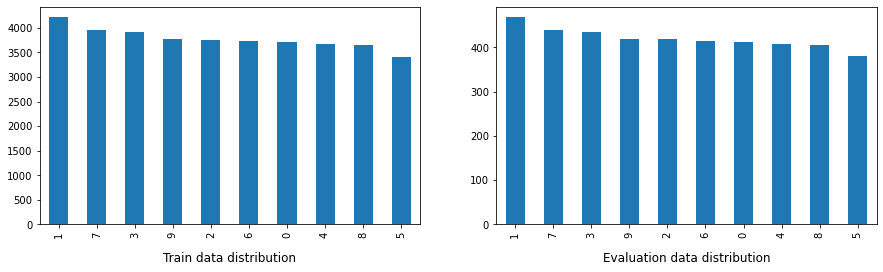

In [14]:
fig = plt.figure(figsize=(15,4))
a = fig.add_subplot(1, 2, 1)
pd.DataFrame({'label':y_train})['label'].value_counts().plot(kind='bar')
a.set_title("Train data distribution", y=-0.2)

a = fig.add_subplot(1, 2, 2)
pd.DataFrame({'label':y_eval})['label'].value_counts().plot(kind='bar')
a.set_title("Evaluation data distribution", y=-0.2)

plt.show()

In [13]:
# Normalizing the values
x_train = x_train / 255.0
x_eval = x_eval / 255.0

test = test / 255.0


y_train = to_categorical(y_train)
y_eval = to_categorical(y_eval)

In [14]:
tr_label[0].shape

(42000,)

In [15]:
y_train.shape

(37800, 10)

In [30]:
curves = dict()

In [16]:
input_shape = (28, 28, 1)
num_classes = 10
batch_size = 500
epochs = 100

In [16]:
optimizers = [
    Adadelta,
    Adagrad,
    Adam,
    Adamax,
    Nadam,
    RMSprop,
    SGD
]

In [32]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [18]:
for optimizer in optimizers:
    print("Using {}:".format(optimizer.__name__))
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=optimizer(learning_rate=0.01),
              metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_eval, y_eval),
          callbacks=[learning_rate_reduction])
    curves[optimizer.__name__] = history
    print('\n\n')

Using Adadelta:
Train on 75600 samples, validate on 4200 samples
Epoch 1/20
75600/75600 [==============================] - 16s 209us/sample - loss: 2.2891 - accuracy: 0.1346 - val_loss: 2.2299 - val_accuracy: 0.5098
Epoch 2/20
75600/75600 [==============================] - 16s 209us/sample - loss: 2.2254 - accuracy: 0.2113 - val_loss: 2.1096 - val_accuracy: 0.6450
Epoch 3/20
75600/75600 [==============================] - 17s 221us/sample - loss: 2.1146 - accuracy: 0.3046 - val_loss: 1.8541 - val_accuracy: 0.7119
Epoch 4/20
75600/75600 [==============================] - 16s 214us/sample - loss: 1.9139 - accuracy: 0.3918 - val_loss: 1.4382 - val_accuracy: 0.7457
Epoch 5/20
75600/75600 [==============================] - 16s 214us/sample - loss: 1.6853 - accuracy: 0.4544 - val_loss: 1.0913 - val_accuracy: 0.7781
Epoch 6/20
75600/75600 [==============================] - 16s 213us/sample - loss: 1.5354 - accuracy: 0.4973 - val_loss: 0.9020 - val_accuracy: 0.8019
Epoch 7/20
75600/75600 [=====

Epoch 14/20
75600/75600 [==============================] - 17s 223us/sample - loss: 0.1249 - accuracy: 0.9630 - val_loss: 0.0322 - val_accuracy: 0.9900
Epoch 15/20
75600/75600 [==============================] - 17s 221us/sample - loss: 0.1136 - accuracy: 0.9657 - val_loss: 0.0342 - val_accuracy: 0.9895
Epoch 16/20
75600/75600 [==============================] - 17s 222us/sample - loss: 0.1101 - accuracy: 0.9671 - val_loss: 0.0337 - val_accuracy: 0.9905
Epoch 17/20
75600/75600 [==============================] - 17s 221us/sample - loss: 0.1027 - accuracy: 0.9695 - val_loss: 0.0364 - val_accuracy: 0.9893
Epoch 18/20
75600/75600 [==============================] - 17s 221us/sample - loss: 0.1056 - accuracy: 0.9680 - val_loss: 0.0297 - val_accuracy: 0.9902
Epoch 19/20
75600/75600 [==============================] - 17s 220us/sample - loss: 0.1059 - accuracy: 0.9681 - val_loss: 0.0381 - val_accuracy: 0.9879
Epoch 20/20
75500/75600 [============================>.] - ETA: 0s - loss: 0.1035 - accu

## Single optimizer

In [33]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

In [3]:
from sklearn.datasets import load_sample_image
# china = load_sample_image("../Primula_flower_in_Himalaya.jpg") / 255
# flower = load_sample_image("../red-rose-flower-658687-2.jpg") / 255
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
print(images.shape)
# outputs = tf.nn.conv2d(images, strides=1, padding='SAME')
# plt.imshow(outputs[0])

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(height,width,channels), padding='SAME'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu', padding='SAME', strides=(1,1)))

images_out = model.predict(images)

(2, 427, 640, 3)


(2, 427, 640, 64)
(427, 640)


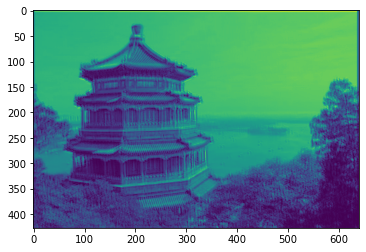

In [4]:
print(images_out.shape)
plt.imshow(images_out[0,:,:,36])
print(images_out[0,:,:,1].shape)

In [34]:
for layer in model.layers:
    print(layer.output_shape)

(None, 24, 24, 32)
(None, 12, 12, 32)
(None, 12, 12, 32)
(None, 8, 8, 64)
(None, 4, 4, 64)
(None, 4, 4, 64)
(None, 1024)
(None, 1000)
(None, 1000)
(None, 10)


In [35]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss=categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_eval, y_eval))

# history = model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_eval, y_eval),
#           callbacks=[learning_rate_reduction])

# history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (x_eval,y_eval),
#                               verbose = 1
#                               )

Epoch 1/100
227/227 [==============================] - 5s 23ms/step - loss: 0.2582 - accuracy: 0.9191 - val_loss: 0.0582 - val_accuracy: 0.9807
Epoch 2/100
227/227 [==============================] - 5s 22ms/step - loss: 0.0666 - accuracy: 0.9788 - val_loss: 0.0400 - val_accuracy: 0.9867
Epoch 3/100
227/227 [==============================] - 5s 21ms/step - loss: 0.0470 - accuracy: 0.9854 - val_loss: 0.0299 - val_accuracy: 0.9907
Epoch 4/100
227/227 [==============================] - 5s 21ms/step - loss: 0.0364 - accuracy: 0.9882 - val_loss: 0.0264 - val_accuracy: 0.9914
Epoch 5/100
227/227 [==============================] - 5s 22ms/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.0278 - val_accuracy: 0.9905
Epoch 6/100
227/227 [==============================] - 5s 21ms/step - loss: 0.0254 - accuracy: 0.9918 - val_loss: 0.0253 - val_accuracy: 0.9907
Epoch 7/100
227/227 [==============================] - 5s 22ms/step - loss: 0.0231 - accuracy: 0.9921 - val_loss: 0.0236 - val_accuracy:

In [ ]:
predictions = model.predict(test)

In [75]:
labels = np.argmax(predictions, axis=1)

In [76]:
result = pd.DataFrame({'ImageId':range(1, len(labels)+1), 'Label':labels})
result.to_csv('submission_digit_recog_cnn_aug_rms.csv', index=False)

In [158]:
37800/500

75.6

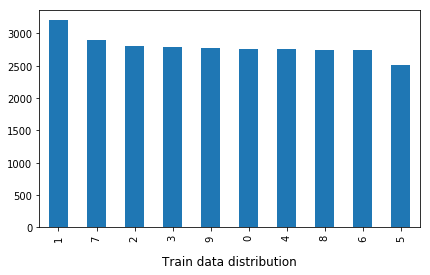

In [159]:
fig = plt.figure(figsize=(15,4))
a = fig.add_subplot(1, 2, 1)
pd.DataFrame({'label':labels})['label'].value_counts().plot(kind='bar')
a.set_title("Train data distribution", y=-0.2)

plt.show()

In [168]:
history.history

{'loss': [0.6577367123275523,
  0.2118982111138326,
  0.13407897211059375,
  0.10130613624911618,
  0.08194766684913288],
 'accuracy': [0.7874074, 0.9337698, 0.9580423, 0.96824074, 0.9742857],
 'val_loss': [0.17425591782445,
  0.0592364092313108,
  0.0919484104074183,
  0.046541281576667516,
  0.034905848714212574],
 'val_accuracy': [0.94095236, 0.97880954, 0.96761906, 0.9861905, 0.9895238],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001]}

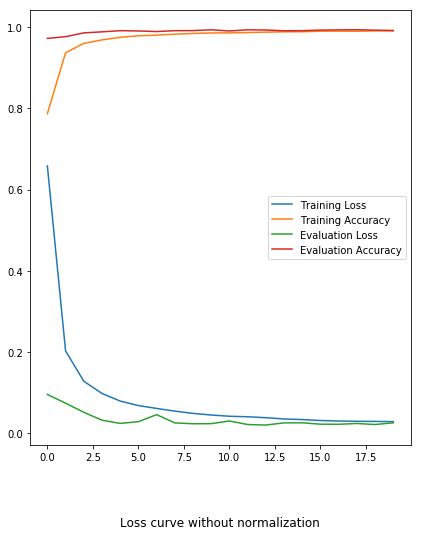

In [183]:
fig = plt.figure(figsize=(15,8))
a = fig.add_subplot(1, 2, 1)
plt.plot(np.arange(epochs), history.history['loss'], label='Training Loss')
plt.plot(np.arange(epochs), history.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(epochs), history.history['val_loss'], label='Evaluation Loss')
plt.plot(np.arange(epochs), history.history['val_accuracy'], label='Evaluation Accuracy')
a.legend()
a.set_title("Loss curve without normalization", y=-0.2)
plt.show()

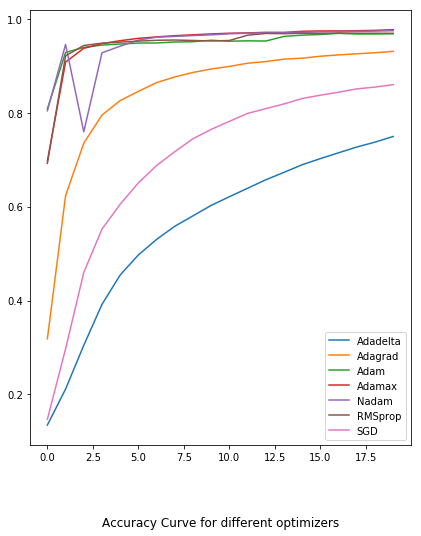

In [24]:
fig = plt.figure(figsize=(15,8))
a = fig.add_subplot(1, 2, 1)
for opt, vals in curves.items():
    plt.plot(np.arange(epochs), vals.history['accuracy'], label=opt)
a.legend()
a.set_title("Accuracy Curve for different optimizers", y=-0.2)
plt.show()

In [4]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [2]:
tf.config.list_physical_devices('GPU')

[]